In [1]:
from classes_ellipsoidales import *    

In [2]:
!pip install -U fortran-magic

Requirement already up-to-date: fortran-magic in /usr/local/lib/python3.8/site-packages (0.7)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
%load_ext fortranmagic

## Routine de rotation des tenseur d'ordre 4 (3x3x3x3) 
A est le tenseur d'origine, R la matrice de rotation (3x3) correspondant à la rotation voulue et B le résultat
Le calcul est bien plus rapide en utilisant des vecteurs de 81 éléments plutôt que des matrices 3x3x3x3 , on utilise transforme donc le matrices avant de les injecter dans cette routine

In [4]:
%%fortran -v

subroutine fast_tensor_rotation(A , R, B)
real, dimension(81),intent(in) :: A
real, dimension(3,3),intent(in) :: R
real ::  product
real, dimension(81), intent(out) :: B

do i = 0,2
    do j = 0,2
        do k = 0,2
            do l = 0,2
                B(27*i + 9*j + 3*k + l + 1) = 0
            end do
        end do
    end do
end do

do i=0,2
    do j = 0,i
        do k = 0,2
            do l = 0,k
                do m = 0,2
                    do n = 0,2
                        do ll = 0,2
                            do kk = 0,2
                                product = R(i+1,m+1)* R(j+1,n+1)*R(k+1,ll+1)*R(l+1,kk+1)
                                B(27*i + 9*j + 3*k + l + 1) =  B(27*i + 9*j + 3*k + l + 1) + A(27*m + 9*n +3*ll + kk +1)*product
                            end do
                        end do
                    end do
                end do
                B(27*j + 9*i + 3*k + l + 1) = B(27*i + 9*j + 3*k + l + 1)
                B(27*i + 9*j + 3*l + k + 1) = B(27*i + 9*j + 3*k + l + 1)
                B(27*j + 9*i + 3*l + k + 1) = B(27*i + 9*j + 3*k + l + 1)
            end do
        end do
    end do
end do




end subroutine fast_tensor_rotation


Ok. The following fortran objects are ready to use: fast_tensor_rotation


## Routine d'inversion de matrice 3x3
L'inversion de CXX est répétée à de très nombreuses reprises dans le calcul du tenseur d'Eshelby, d'où l'utilisation d'une routine pour gagner du temps

In [5]:
%%fortran -v

subroutine inversionT(A,S)
real, dimension(3,3),intent(in) :: A
real, dimension(3,3),intent(out) :: S
real :: det

det = A(1,1)*A(2,2)*A(3,3) + A(1,2)*A(2,3)*A(3,1) + A(1,3)*A(2,1)*A(3,2) 
det = det - A(3,2)*A(2,3)*A(1,1) - A(3,3)*A(2,1)*A(1,2) - A(3,1)*A(2,2)*A(1,3)

S(1,1) = (A(2,2)*A(3,3)-A(3,2)*A(2,3))/det
S(2,1) = -(A(1,2)*A(3,3)-A(3,2)*A(1,3))/det
S(3,1) = (A(1,2)*A(2,3)-A(2,2)*A(1,3))/det

S(1,2) = -(A(2,1)*A(3,3)-A(3,1)*A(2,3))/det
S(2,2) = (A(1,1)*A(3,3)-A(3,1)*A(1,3))/det
S(3,2) = -(A(1,1)*A(2,3)-A(2,1)*A(1,3))/det

S(1,3) = (A(2,1)*A(3,2)-A(3,1)*A(2,2))/det
S(2,3) = -(A(1,1)*A(3,2)-A(3,1)*A(1,2))/det
S(3,3) = (A(1,1)*A(2,2)-A(2,1)*A(1,2))/det


end subroutine inversionT


Ok. The following fortran objects are ready to use: inversiont


In [6]:
def Fast_eshelby_tensor(Axis,Em,nu) : 
    
    Sm = Matrice_Souplesse_Isotrope(Em,nu)
    Cm = inv(Sm)
    Cm3 = Comp66_to_3333(Cm)
    a0,a1,a2 = Axis
    IJV = np.array([[0,0],[1,1],[2,2],[1,2],[0,2],[0,1]])
    Nit = 40
    Ntop = Nit
    Mtop = Nit
    dphi = pi/(Ntop-1)
    dtheta = pi/(Ntop-1)
    A = np.zeros((6,6))
    B = np.zeros((6,6,Mtop))
    G = np.zeros((6,6,Ntop))
    E = np.zeros((6,6))
    
    # Integration de la fonction de green sur la demi ellipsoïde
    for m in range(Mtop) : 
        phi = m*dphi
        for n in range(Ntop) : 
            theta = n*dtheta
            X = np.array([sin(theta)*cos(phi)/a0 , sin(theta)*sin(phi)/a1 , cos(theta)/a2])
            TCXX = np.zeros((3,3))
            for i in range(3) :
                for j in range(3) :
                    for k in range(3) : 
                        for l in range(3) :
                            TCXX[i,k] += Cm3[k,j,i,l]*X[j]*X[l] ## Calcul de la transposée de CXX
             
            CXX = inversiont(TCXX)  ## Calcul de l'inverse de CXX par Fortran
            
            for i in range(6) :
                for j in range(6) :                     
                    I1 = IJV[i,0]
                    J1 = IJV[j,0]
                    I2 = IJV[i,1]
                    J2 = IJV[j,1]
                    G[i,j,n] = 0.5 * sin(theta) * (CXX[I1,J1]*X[I2]*X[J2] + CXX[I2,J1]*X[I1]*X[J2] + CXX[I1,J2]*X[I2]*X[J1] + CXX[I2,J2]*X[I1]*X[J1])
        
        
        B[:,:,m] = 0.5 * dtheta * (G[:,:,0]+G[:,:,Ntop-1])
        for i in range(1,Ntop-1) : 
            B[:,:,m] +=  dtheta * G[:,:,i]

    A = 0.5*(B[:,:,0]+B[:,:,Ntop-1])* dphi/(4*pi)
    for i in range(1,Ntop-1) : 
         A += B[:,:,i]* dphi/(4*pi)  
    
    for i in range(6) : 
        for j in range(6) : 
            E[i,j]=A[i,0]*Cm[0,j]+A[i,1]*Cm[1,j]+A[i,2]*Cm[2,j] + 4* (A[i,3]*Cm[3,j]+A[i,4]*Cm[4,j]+A[i,5]*Cm[5,j]) 
    
    return E 

# Modele de Mori-Tanaka

In [7]:
def Mori_tanaka(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        # Création des matrices de rotations
        Rotation_Matrix = Rotation_matrices(n_renforts)
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Fast_eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            
            V3 = Comp66_to_3333(V6i)
            V3L = Matrix_to_vecteur(V3)
            for j in range(n_renforts) :                 
                V3RL = fast_tensor_rotation(V3L,Rotation_Matrix[j])
                V3R = Vecteur_to_matrix(V3RL)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        Sh = inv(Ch)
        
        return {'C' : Ch, 'S' : Sh}

# Modele Autocoherent

In [8]:
def Self_Consistent(Cm, inclusion_behaviors):
    # Paramètres internes du modèles         
    n_renforts = 1     # paramètre non physique qui permet de forcer l'isotropie
    n_points_fixe = 5   # précise le nombre de pas de dilution (pour l'initialisation du point fixe)
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    seuil_divergence = 100 # Nombre d'itération au bou duquel on considère le modèle comme divergent
    ### Seulement pour le test ####
    LE = np.zeros(n_points_fixe+1)
    F = np.zeros(n_points_fixe+1)
    ################################
    Sm = Cm['S']
    Cm = Cm['C']
    Id = np.identity(6) 
    n_inclusions = len(inclusion_behaviors)

    # Création des matrices de rotations
    Rotation_Matrix = Rotation_matrices(n_renforts)
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm

    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_points_fixe+1) :
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        convergence = 2
        n_boucles = 0
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        #print(i," pas sur ",n_points_fixe)
        while convergence>precision : 
            
            # Comptage du nombre de boucle pour l'arrêter en cas de divergence
            n_boucles += 1   
            if n_boucles >seuil_divergence : 
                raise NameError('Self-Consistent model diverge for the values prescribed from the step '+str(i))
                
                
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch

            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Cf = inclusion_behaviors[j][0]['C']
                fi_pas = inclusion_behaviors[j][1]*i/n_points_fixe
                fi_1_renfort = fi_pas/n_renforts 
                a2,a3 = inclusion_behaviors[j][2]
                A = 1,a2,a3
                
                Esh = Fast_eshelby_tensor(A,Eh,nuh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                
                V6 = np.dot(Cf-Cm,Aesh)
                V3 = Comp66_to_3333(V6)

                # Ajout des contribution de chaque renfort en fonction de son orientation
                V3L = Matrix_to_vecteur(V3)
                for k in range(n_renforts) :                 
                    V3RL = fast_tensor_rotation(V3L,Rotation_Matrix[k])
                    V3R = Vecteur_to_matrix(V3RL)
                    V = Comp3333_to_66(V3R)
                    W += fi_1_renfort * V
            Ch = Cm + W

            # Actualisation du matériau homogénéisé
            Cp = Ch

            # Test de sortie
            E = Young_isotropeC(Cp)
            nu = nu_isotropeC(Cp)
            convergence = abs((E-Eh)/Eh)+abs((nu-nuh)/nuh)
            
            Eh = E
            nuh = nu           

            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
        print("f = ",fi_pas)
        print("E = ",E)
        print("nu = ",nu)
        print("******************")
        ### Seulement pour le test ###
        LE[i] = E
        F[i] = fi_pas
        ############################

    #return {'C' : Cp, 'S' : Sp}
    return LE,F

# Modèle Differentiel

In [9]:
def Differential(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch (f+df) = Ch(f) + 1/fm * Somme sur i (dfi*(Ci-Ch)*Aeshi)  avec Aeshi = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 1     # paramètre non physique qui permet de forcer lisotropie
        n_pas = 100
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.eye(6) 

        # Création des matrices de rotations
        Rotation_Matrix = Rotation_matrices(n_renforts)
        
        # Initialisation de la solution diluée : 
        Ch = Cm
        Sh = Sm        
        
        # Calculs préléminaires :
        Esh = []
        df = []
        Cf = []
        for i in range (len(inclusion_behaviors)) :
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])     
            
            Esh.append(Fast_eshelby_tensor(Ai,Em,num))
            df.append(fi/n_pas)
            Cf.append(Cfi)
            
        # Boucle d'incrementation de la concentration
        for k in range (1,n_pas+1) :             
            dCh = np.zeros((6,6))
            fm_pas = 1
            for i in range(len(inclusion_behaviors)) :
                DCi = Cf[i]-Ch
                Aeshi = inv(Id + np.matmul(Esh[i],np.matmul(Sh,DCi)))                
                fi_pas = df[i]*k
                fm_pas -= fi_pas
                
                # Ajout des contribution de chaque renfort en fonction de son orientation     
                DCi3 = Comp66_to_3333(DCi)
                DCi3L = Matrix_to_vecteur(DCi3)
                DCi3RL = np.zeros(81)
                for j in range(n_renforts) :                                    
                    DCi3RL += fast_tensor_rotation(DCi3L,Rotation_Matrix[j])                  
                    DCi3R = Vecteur_to_matrix(DCi3RL)
                    DCi6 = Comp3333_to_66(DCi3R)
                    RCi = df[i]/n_renforts * DCi6
                    dCh += np.matmul(RCi,Aeshi)

            Ch = Ch + 1/fm_pas*dCh
            Sh = inv(Ch)
            
            E = Young_isotropeC(Ch)
            nu = nu_isotropeC(Ch)


        return {'C' : Ch, 'S' : Sh}
    

f= 0.0


/app/homogeneisation/classes_ellipsoidales.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  x = 2 * (C[0,0]+C[1,1]+C[2,2]) / (C[0,1]+C[0,2]+C[1,2]+C[1,0]+C[2,0]+C[2,1])


f= 0.05263157894736842
f= 0.10526315789473684
f= 0.15789473684210525
f= 0.21052631578947367
f= 0.2631578947368421
f= 0.3157894736842105
f= 0.3684210526315789
f= 0.42105263157894735
f= 0.47368421052631576
f= 0.5263157894736842
f= 0.5789473684210527
f= 0.631578947368421
f= 0.6842105263157894
f= 0.7368421052631579
f= 0.7894736842105263
f= 0.8421052631578947
f= 0.894736842105263
f= 0.9473684210526315
f= 1.0


<ipython-input-9-6282d70ca30e>:59: RuntimeWarning: divide by zero encountered in double_scalars
  Ch = Ch + 1/fm_pas*dCh
/app/homogeneisation/classes_ellipsoidales.py:206: RuntimeWarning: invalid value encountered in double_scalars
  x = 2 * (C[0,0]+C[1,1]+C[2,2]) / (C[0,1]+C[0,2]+C[1,2]+C[1,0]+C[2,0]+C[2,1])


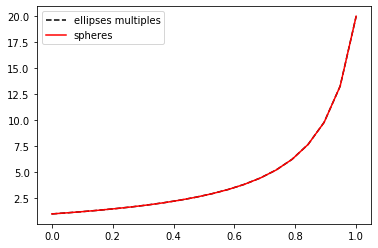

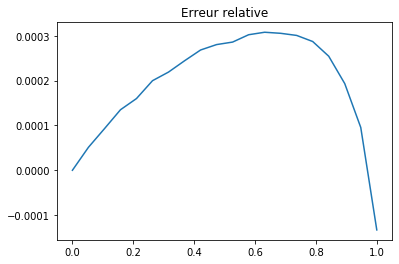

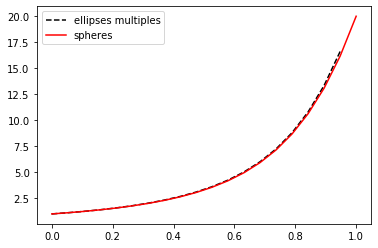

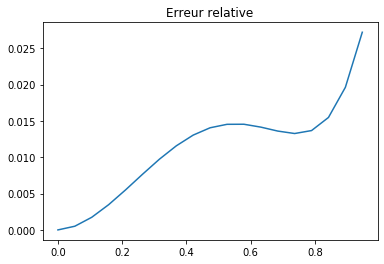

/app/homogeneisation/classes_ellipsoidales.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  x = 2 * (C[0,0]+C[1,1]+C[2,2]) / (C[0,1]+C[0,2]+C[1,2]+C[1,0]+C[2,0]+C[2,1])
<ipython-input-8-058334d589fa>:71: RuntimeWarning: invalid value encountered in double_scalars
  convergence = abs((E-Eh)/Eh)+abs((nu-nuh)/nuh)


f =  0.0
E =  1.0
nu =  0.0
******************


<ipython-input-8-058334d589fa>:71: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = abs((E-Eh)/Eh)+abs((nu-nuh)/nuh)


f =  0.2
E =  1.5938151112715162
nu =  0.05546866195439912
******************
f =  0.4
E =  3.0614500375859346
nu =  0.09313851527718307
******************
f =  0.6
E =  6.926263449195669
nu =  0.08421537562875506
******************
f =  0.8
E =  13.102213903993013
nu =  0.040882106845639615
******************
f =  1.0
E =  19.999997032185377
nu =  1.0554990074169912e-08
******************
f= 0.0
f= 0.2
f= 0.4
f= 0.6
f= 0.8
f= 1.0


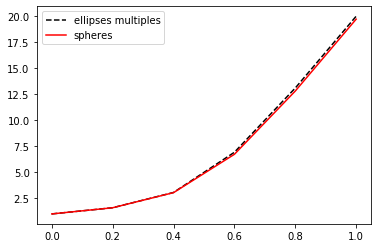

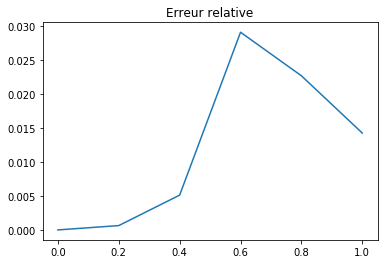

In [10]:
from classes_v2 import * 
from classes_ellipsoidales import *    
Ef,Em = 20,1
nuf,num = 0.,0.
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

ff =  1
LEA3,LEAr,LEMT3,LED3,LEDr,LEMTr = [],[],[],[],[],[]
LEMT2,LED2 = [],[]
F1 = np.linspace(0,ff,20)
for i in range(len(F1)) : 
    f = F1[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    E2 =Young_isotropeC( Mori_tanaka(matrix_behavior,[[inclusion_behavior,f,ar]])['C'])
    E3 = Mori_Tanaka().compute_h_behavior(microstructure)['E']
    #E2 = Young_isotropeC(Differentiel(matrix_behavior,[[inclusion_behavior,f,ar]])['C'])
    #E2 = LE2[i]
    Er = (E2-E3)/E3    
    
    LEMT2.append(E2)
    LEMT3.append(E3)
    LEMTr.append(Er)

    E2 = Young_isotropeC(Differential(matrix_behavior,[[inclusion_behavior,f,ar]])['C'])
    E3 = Differential_Scheme().compute_h_behavior(microstructure)['E']
    Er = (E2-E3)/E3

    
    LED2.append(E2)
    LED3.append(E3)
    LEDr.append(Er)
    
plt.plot(F1,LEMT2,'--k',label = "ellipses multiples")
plt.plot(F1,LEMT3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F1,LEMTr)
plt.title("Erreur relative")
plt.show()

plt.plot(F1,LED2,'--k',label = "ellipses multiples")
plt.plot(F1,LED3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F1,LEDr)
plt.title("Erreur relative")
plt.show()

LEA2,F = Self_Consistent(matrix_behavior,[[inclusion_behavior,ff,ar]])
for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    E2 =LEA2[i]
    E3 = Autocoherent_Hill().compute_h_behavior(microstructure)['E']
   
    Er = (E2-E3)/E3
    
    LEA3.append(E3)
    LEAr.append(Er)
    
plt.plot(F,LEA2,'--k',label = "ellipses multiples")
plt.plot(F,LEA3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F,LEAr)
plt.title("Erreur relative")
plt.show()